In [12]:
import pandas as pd
import numpy as np 
import seaborn as sns
from pylab import rcParams
import os 
from typing import TypeVar, Callable, Sequence
from functools import reduce
T=TypeVar('T')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict,train_test_split,GridSearchCV
from sklearn.feature_selection import RFECV,SelectFromModel,SelectKBest
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics 
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout,GRU
from keras.optimizers import Adam, SGD
import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [13]:
class stock_prediction():
    def __init__(self, stocks, models):
        self.stocks = stocks
        # BUG 16 FIX: renamed attribute from 'train_model' to 'model_list'
        # to avoid collision with the train_model() method
        self.model_list = models
        self.metrics = {}

    def get_stock_data(self, Ticker):
        # BUG 2 NOTE: using self.Ticker which is set in pipeline_sequence
        Ticker = self.Ticker
        file = Ticker + '.csv'
        stock = pd.read_csv(file, index_col='Date')
        print(stock.columns)
        print("loading data for " + self.Ticker)

        # BUG 1 FIX: use actual CSV column names instead of non-existent ones
        # The CSV has: 'QQQ(t-1)', 'Snp(t-1)', 'DJIA(t-1)', 'Upper_band' (lowercase b)
        feature_selected = [
            'Open', 'High', 'Low', 'Close(t)',
            'QQQ(t-1)', 'Snp(t-1)', 'DJIA(t-1)',
            'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_band',
        ]
        print(stock.columns.tolist())
        missing = [c for c in feature_selected if c not in stock.columns]
        print("MISSING COLUMNS:", missing)

        self.df_stock = stock[feature_selected]

        # BUG 3 FIX: assign the result of rename() back
        self.df_stock = self.df_stock.rename(columns={'Close(t)': 'Close'})
        self.df_stock = self.df_stock.copy()

        self.df_stock['High-Low'] = self.df_stock['High'] - self.df_stock['Low']
        self.df_stock['Diff'] = self.df_stock['Close'] - self.df_stock['Open']

        # BUG 4 & 5 FIX: use correct column names matching what we actually have
        feature_selected = [
            'Close', 'Diff', 'High-Low',           # BUG 4 FIX: 'High-low' -> 'High-Low'
            'QQQ(t-1)', 'Snp(t-1)', 'DJIA(t-1)',   # BUG 5 FIX: use actual CSV column names
            'ATR', 'RSI', 'MA50', 'EMA200', 'Upper_band',
        ]
        self.df_stock = self.df_stock[feature_selected]
        self.df_stock = self.df_stock[1000:-70]

        print(self.df_stock.columns)

    def prepare_lagged_features(self, lag_diff, lag_stock, lag_index):
        print('preparing lagged features for stock, index funds.....')

        # BUG 6 FIX: use loop variable 'l' in f-string and shift(), not hardcoded 1
        lags = range(1, lag_stock + 1)
        lag_cols = ['Close']
        self.df_stock = self.df_stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        # BUG 6 FIX (continued): use 'l' consistently as loop variable
        lags = range(1, lag_index + 1)
        lag_cols = ['QQQ(t-1)', 'Snp(t-1)', 'DJIA(t-1)']
        self.df_stock = self.df_stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        self.df_stock = self.df_stock.drop(columns=lag_cols)

        lags = range(1, lag_diff + 1)
        lag_cols = ['Diff', 'High-Low']
        self.df_stock = self.df_stock.assign(**{
            '{}(t-{})'.format(col, l): self.df_stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })
        self.df_stock = self.df_stock.drop(columns=lag_cols)

        remove_lags_na = max(lag_stock, lag_index, lag_diff) + 1
        # BUG 29 FIX: str() was outside print()
        print('Removing the NAN rows- ', str(remove_lags_na))
        self.df_stock = self.df_stock.iloc[remove_lags_na:, ]
        return self.df_stock

    def get_lagged_features(self, ticker):
        self.df_stock_lagged = self.prepare_lagged_features(
            lag_stock=25, lag_index=10, lag_diff=5
        )
        print(self.df_stock_lagged.columns)
        self.df_stock = self.df_stock_lagged
        print(self.df_stock.shape)
        print(self.df_stock.columns)

    def create_train_test_split(self):
        # BUG 7 FIX: was drop(columns=['Close', axis==1]) — invalid syntax
        self.features = self.df_stock.drop(columns='Close')
        self.target = self.df_stock['Close']

        # BUG 8 FIX: .Shape -> .shape (Python is case-sensitive)
        data_len = self.df_stock.shape[0]
        print('Historic Stock data length is - ', str(data_len))

        train_split = int(data_len * 0.88)
        print('Training set length- ', str(train_split))

        val_split = train_split + int(data_len * 0.1)
        # BUG 9 FIX: len() on a float crashes — use int() instead
        print('Validation dataset length- ', str(int(data_len * 0.02)))

        # BUG 10 FIX: self.features[val_split] -> self.features[val_split:]
        x_train = self.features[:train_split]
        x_val = self.features[train_split:val_split]
        x_test = self.features[val_split:]

        y_train = self.target[:train_split]
        y_val = self.target[train_split:val_split]
        y_test = self.target[val_split:]

        print(x_train.shape, x_test.shape, x_val.shape)
        print(y_train.shape, y_test.shape, y_val.shape)
        return x_train, x_test, x_val, y_train, y_test, y_val

    def get_train_test(self):
        print('splitting the data into train and test')
        print(' ')
        if self.ML_model == 'LSTM':
            # BUG 20 FIX: scale_LSTM_features -> scale_LSTM
            self.scale_LSTM()
            self.x_train, self.x_test, self.y_train, self.y_test = self.create_train_test_LSTM()
        else:
            # BUG 11 FIX: unpacking order was wrong (y_test and y_train swapped)
            self.x_train, self.x_test, self.x_val, self.y_train, self.y_test, self.y_val = self.create_train_test_split()

    def get_mape(self, y_true, y_pred):
        """Mean absolute percentage error (MAPE)"""
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    def cal_metrics(self):
        print('Evaluating metrics- MAE, MAPE, RMSE, R SQUARE')
        print(' ')
        if self.ML_model == 'LSTM':
            self.train_RSq = round(metrics.r2_score(self.y_train, self.y_train_pred), 2)
            self.train_EV = round(metrics.explained_variance_score(self.y_train, self.y_train_pred), 2)
            self.train_MAPE = round(self.get_mape(self.y_train, self.y_train_pred), 2)
            self.train_MSE = round(metrics.mean_squared_error(self.y_train, self.y_train_pred), 2)
            self.train_RMSE = round(np.sqrt(metrics.mean_squared_error(self.y_train, self.y_train_pred)), 2)
            self.train_MAE = round(metrics.mean_absolute_error(self.y_train, self.y_train_pred), 2)

            self.test_RSq = round(metrics.r2_score(self.y_test, self.y_test_pred), 2)
            self.test_EV = round(metrics.explained_variance_score(self.y_test, self.y_test_pred), 2)
            self.test_MAPE = round(self.get_mape(self.y_test, self.y_test_pred), 2)
            self.test_MSE = round(metrics.mean_squared_error(self.y_test, self.y_test_pred), 2)
            # BUG 14 FIX: was using mean_absolute_error for RMSE
            self.test_RMSE = round(np.sqrt(metrics.mean_squared_error(self.y_test, self.y_test_pred)), 2)
            self.test_MAE = round(metrics.mean_absolute_error(self.y_test, self.y_test_pred), 2)
        else:
            # BUG 12 FIX: self.train_pred -> self.y_train_pred (consistent naming)
            self.train_RSq = round(metrics.r2_score(self.y_train, self.y_train_pred), 2)
            self.train_EV = round(metrics.explained_variance_score(self.y_train, self.y_train_pred), 2)
            self.train_MAPE = round(self.get_mape(self.y_train, self.y_train_pred), 2)
            # BUG 13 FIX: parentheses were wrong — (y_true, y_pred) was a tuple
            self.train_MSE = round(metrics.mean_squared_error(self.y_train, self.y_train_pred), 2)
            self.train_RMSE = round(np.sqrt(metrics.mean_squared_error(self.y_train, self.y_train_pred)), 2)
            self.train_MAE = round(metrics.mean_absolute_error(self.y_train, self.y_train_pred), 2)

            # BUG 12 FIX: self.val_pred -> self.y_val_pred
            self.val_RSq = round(metrics.r2_score(self.y_val, self.y_val_pred), 2)
            self.val_EV = round(metrics.explained_variance_score(self.y_val, self.y_val_pred), 2)
            self.val_MAPE = round(self.get_mape(self.y_val, self.y_val_pred), 2)
            self.val_MSE = round(metrics.mean_squared_error(self.y_val, self.y_val_pred), 2)
            self.val_RMSE = round(np.sqrt(metrics.mean_squared_error(self.y_val, self.y_val_pred)), 2)
            self.val_MAE = round(metrics.mean_absolute_error(self.y_val, self.y_val_pred), 2)

            # BUG 12 FIX: self.test_pred -> self.y_test_pred
            self.test_RSq = round(metrics.r2_score(self.y_test, self.y_test_pred), 2)
            self.test_EV = round(metrics.explained_variance_score(self.y_test, self.y_test_pred), 2)
            self.test_MAPE = round(self.get_mape(self.y_test, self.y_test_pred), 2)
            self.test_MSE = round(metrics.mean_squared_error(self.y_test, self.y_test_pred), 2)
            self.test_RMSE = round(np.sqrt(metrics.mean_squared_error(self.y_test, self.y_test_pred)), 2)
            self.test_MAE = round(metrics.mean_absolute_error(self.y_test, self.y_test_pred), 2)

    def update_metrics(self):
        print("update the metrics tracker....")
        if self.ML_model == 'LSTM':
            # BUG 15 FIX: PascalCase -> camelCase to match cal_metrics()
            self.metrics[self.Ticker][self.ML_model] = {
                'Train_MAE': self.train_MAE, 'Train_RSq': self.train_RSq,
                'Train_MAPE': self.train_MAPE, 'Train_RMSE': self.train_RMSE,
                'Test_MAE': self.test_MAE, 'Test_RSq': self.test_RSq,
                'Test_MAPE': self.test_MAPE, 'Test_RMSE': self.test_RMSE,
            }
        else:
            self.metrics[self.Ticker][self.ML_model] = {
                'Train_MAE': self.train_MAE, 'Train_RSq': self.train_RSq,
                'Train_MAPE': self.train_MAPE, 'Train_RMSE': self.train_RMSE,
                'Val_MAE': self.val_MAE, 'Val_RSq': self.val_RSq,
                'Val_MAPE': self.val_MAPE, 'Val_RMSE': self.val_RMSE,
            }

    # BUG 16 FIX: method renamed from train_model -> run_training
    # to avoid collision with the self.train_model attribute (now self.model_list)
    def run_training(self, ticker):
        # BUG 16 FIX: self.train_model -> self.model_list
        for model in self.model_list:
            self.ML_model = model
            if self.ML_model == 'Linear Regression':
                print('  ')
                print('Training Linear Regression model')
                self.get_train_test()

                # BUG 17 FIX: plty -> plt
                plt.plot(self.y_train)
                plt.plot(self.y_val)
                plt.plot(self.y_test)
                # BUG 18 FIX: plt.legend needs a list
                plt.legend(['Train', 'Val', 'Test'])
                plt.title('Stock price time series')
                plt.show()

                from sklearn.linear_model import LinearRegression
                lr = LinearRegression()
                lr.fit(self.x_train, self.y_train)

                # BUG 19 FIX: predictions & metrics were missing after fit
                self.y_train_pred = lr.predict(self.x_train)
                self.y_val_pred = lr.predict(self.x_val)
                self.y_test_pred = lr.predict(self.x_test)

                self.cal_metrics()
                self.update_metrics()
                self.plot_prediction()

            elif self.ML_model == 'Random Forest':
                print('  ')
                print('Training Random Forest model')
                self.get_train_test()

                rf = RandomForestRegressor(n_estimators=100, random_state=42)
                rf.fit(self.x_train, self.y_train)

                self.y_train_pred = rf.predict(self.x_train)
                self.y_val_pred = rf.predict(self.x_val)
                self.y_test_pred = rf.predict(self.x_test)

                self.cal_metrics()
                self.update_metrics()
                self.plot_prediction()

            elif self.ML_model == 'XGBoost':
                print('  ')
                print('Training XGBoost model')
                self.get_train_test()

                from xgboost import XGBRegressor
                xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
                xgb.fit(self.x_train, self.y_train)

                self.y_train_pred = xgb.predict(self.x_train)
                self.y_val_pred = xgb.predict(self.x_val)
                self.y_test_pred = xgb.predict(self.x_test)

                self.cal_metrics()
                self.update_metrics()
                self.plot_prediction()

            elif self.ML_model == 'LSTM':
                print('  ')
                print('Training LSTM model')
                self.get_train_test()
                self.get_LSTM_model()

                # Inverse transform predictions
                self.y_train_pred = self.scaler_t.inverse_transform(
                    self.lstm.predict(self.x_train)
                )
                self.y_test_pred = self.scaler_t.inverse_transform(
                    self.lstm.predict(self.x_test)
                )
                # Inverse transform actual values
                self.y_train = self.scaler_t.inverse_transform(self.y_train)
                self.y_test = self.scaler_t.inverse_transform(self.y_test)

                self.cal_metrics()
                self.update_metrics()

    def scale_LSTM(self):
        print("scaling features and targeting the LSTM")
        from sklearn.preprocessing import MinMaxScaler

        # Separating features from target
        features = self.df_stock.drop(columns='Close', axis=1)
        target = self.df_stock['Close']
        target = target.values.reshape(-1, 1)

        # Scale features
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.feature_SS = self.scaler.fit_transform(features)

        # Scale target
        self.scaler_t = MinMaxScaler(feature_range=(-1, 1))
        self.target_SS = self.scaler_t.fit_transform(target)

        # BUG 21 FIX: consistent naming — use features_SS for the DataFrame version
        self.features_SS = pd.DataFrame(self.feature_SS)
        self.features_SS.columns = features.columns.tolist()

    def plot_prediction(self):
        print(' ')
        print('Predicted vs actual for', self.ML_model)
        self.df_pred = pd.DataFrame(
            self.y_val.values, columns=['Actual'], index=self.y_val.index
        )
        self.df_pred['Predicted'] = self.y_val_pred
        self.df_pred = self.df_pred.reset_index()
        self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')
        print('Stock prediction on test data- ', self.ML_model)
        print('Plotting actual vs predicted for- ', self.ML_model)
        self.df_pred[['Actual', 'Predicted']].plot()
        plt.title('Actual vs Predicted stock prices')
        plt.show()

    def create_train_test_LSTM(self):
        # BUG 21 FIX: use features_SS (DataFrame) then convert to array
        feature_array = self.features_SS.values
        target_array = self.target_SS

        data_len = feature_array.shape[0]
        print("fetching historical data- ", str(data_len))

        train_split = int(data_len * 0.87)
        print('Training Set length - ', str(train_split))
        print('Test Set length - ', str(int(data_len * 0.13)))

        X_train = feature_array[:train_split]
        X_test = feature_array[train_split:]
        Y_train = target_array[:train_split]
        Y_test = target_array[train_split:]

        # Reshape for LSTM [samples, time_steps, features]
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        print(X_train.shape, X_test.shape)
        print(Y_train.shape, Y_test.shape)

        # BUG 22 FIX: return order was Y_test, Y_train — swapped
        return X_train, X_test, Y_train, Y_test

    def get_LSTM_model(self):
        # BUG 23 FIX: ReduceLROnPlatue -> ReduceLROnPlateau
        from keras.callbacks import ReduceLROnPlateau

        self.lstm = Sequential()
        # BUG 26 FIX: self.X_train -> self.x_train (consistent casing)
        self.lstm.add(LSTM(
            32, return_sequences=True, recurrent_dropout=0.2, dropout=0.2,
            input_shape=(self.x_train.shape[1], 1)
        ))
        self.lstm.add(LSTM(32, dropout=0.2))
        self.lstm.add(Dense(1, activation='linear'))

        rlrop = ReduceLROnPlateau(
            monitor='val_mean_absolute_error', factor=0.1, patience=2
        )
        # BUG 24 FIX: lr -> learning_rate
        opt = SGD(learning_rate=0.001, momentum=0.8)
        self.lstm.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
        self.lstm.summary()

        # BUG 25 FIX: epoch -> epochs
        # BUG 26 FIX: self.x_train, self.y_train (lowercase)
        self.history_lstm = self.lstm.fit(
            self.x_train, self.y_train,
            batch_size=16, epochs=20,
            validation_data=(self.x_test, self.y_test),
            callbacks=[rlrop],
            shuffle=False
        )
        return self.history_lstm

    def save_results(self, ticker):
        import json
        print('Saving the data for the stock- ', self.Ticker)
        with open('metrics.txt', 'w') as json_file:
            json.dump(self.metrics, json_file)

    def pipeline(self, value: T, function_pipeline: Sequence[Callable[[T], T]]) -> T:
        return reduce(lambda v, f: f(v), function_pipeline, value)

    def pipeline_sequence(self):
        for stock in self.stocks:
            self.Ticker = stock
            self.metrics[self.Ticker] = {}
            print('Initiating Pipeline for Stock Ticker ---- ', self.Ticker)
            z = self.pipeline(
                value=self.Ticker,
                function_pipeline=(
                    self.get_stock_data,
                    self.get_lagged_features,
                    # BUG 16 FIX: self.train_model -> self.run_training
                    self.run_training,
                    self.save_results,
                )
            )
            print(f'z={z}')


In [14]:
import matplotlib.pyplot as plt

stocks = ['NKE', 'IBM', 'KO', 'GS', 'JNJ', 'NVDA']
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LSTM']
training = stock_prediction(stocks, models)
training.pipeline_sequence()

Initiating Pipeline for Stock Ticker ----  NKE
Index(['Open', 'High', 'Low', 'Close(t)', 'Volume', 'SD_20', 'Upper_band',
       'Lower_band', 'S_close(t-1)', 'S_open(t-1)', 'S_close(t-2)',
       'S_open(t-2)', 'S_close(t-3)', 'S_open(t-3)', 'S_close(t-5)',
       'S_open(t-5)', 'MA5', 'MA10', 'MA20', 'MA50', 'MA200', 'EMA10', 'EMA20',
       'EMA50', 'EMA100', 'EMA200', 'MACD', 'MACD_EMA', 'ATR', 'ADX', 'CCI',
       'ROC', 'RSI', 'williams %R', 'So%k', 'STD5', 'Force_index1',
       'Force_index20', 'Date_col', 'day', 'Dayofweek', 'week', 'Dayofyear',
       'month', 'is_month_end', 'is_month_start', 'is_quarter_end',
       'is_quarter_start', 'is_year_end', 'is_leap_year', 'year', 'QQQ(t-1)',
       'QQQ(t-2)', 'QQQ(t-5)', 'QQQ_MA10', 'QQQ_MA20', 'QQQ_MA50', 'Snp(t-1)',
       'Snp(t-5)', 'DJIA(t-1)', 'DJIA(t-5)', 'Close_forecast'],
      dtype='object')
loading data for NKE
['Open', 'High', 'Low', 'Close(t)', 'Volume', 'SD_20', 'Upper_band', 'Lower_band', 'S_close(t-1)', 'S_open(

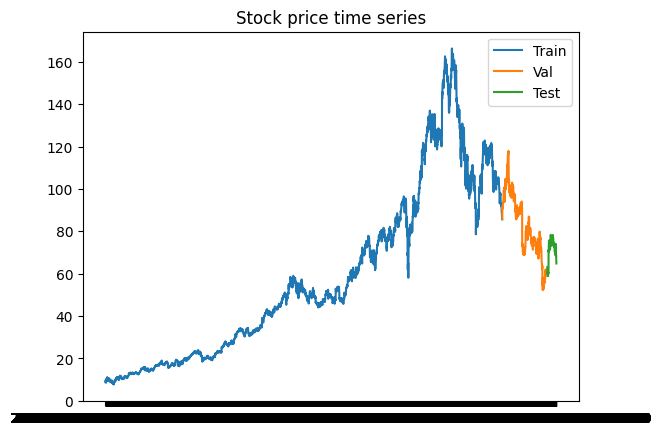

Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Linear Regression
Stock prediction on test data-  Linear Regression
Plotting actual vs predicted for-  Linear Regression


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


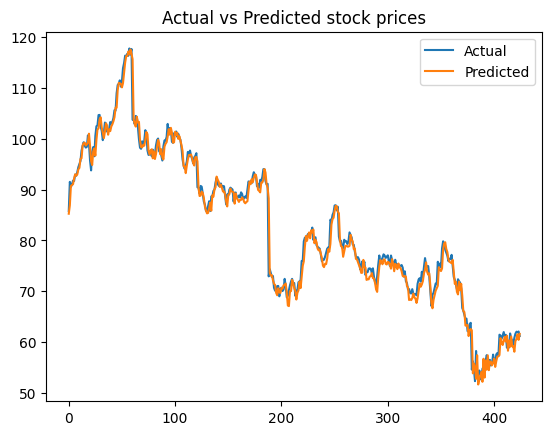

  
Training Random Forest model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Random Forest
Stock prediction on test data-  Random Forest
Plotting actual vs predicted for-  Random Forest


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


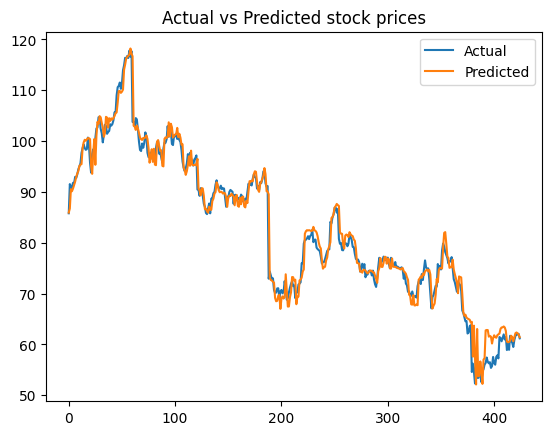

  
Training XGBoost model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for XGBoost
Stock prediction on test data-  XGBoost
Plotting actual vs predicted for-  XGBoost


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


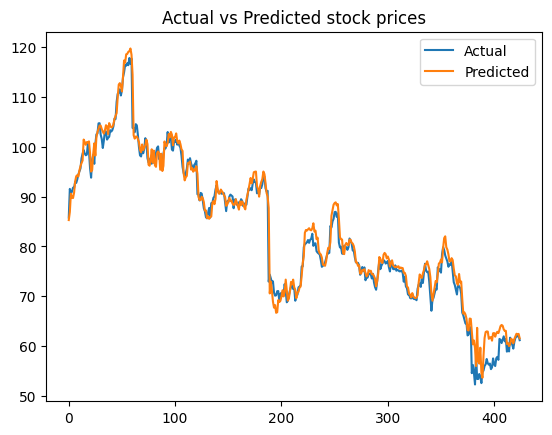

  
Training LSTM model
splitting the data into train and test
 
scaling features and targeting the LSTM
fetching historical data-  4254
Training Set length -  3700
Test Set length -  553
(3700, 70, 1) (554, 70, 1)
(3700, 1) (554, 1)


c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 70, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.2428 - mae: 0.3641 - val_loss: 0.2002 - val_mae: 0.4060 - learning_rate: 0.0010
Epoch 2/20
  7/232 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1.4113 - mae: 1.1870

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.3577 - mae: 0.4500 - val_loss: 0.1945 - val_mae: 0.3983 - learning_rate: 0.0010
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.3472 - mae: 0.4487 - val_loss: 0.2022 - val_mae: 0.4067 - learning_rate: 0.0010
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.3294 - mae: 0.4370 - val_loss: 0.2223 - val_mae: 0.4297 - learning_rate: 0.0010
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.3083 - mae: 0.4197 - val_loss: 0.2367 - val_mae: 0.4452 - learning_rate: 0.0010
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2677 - mae: 0.3844 - val_loss: 0.2485 - val_mae: 0.4588 - learning_rate: 0.0010
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2532 - mae: 0.3717 - val_loss: 0.2657 - val_mae: 0.4779 - learning_rate: 0.0010
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2329 - mae: 0.3510 - val_loss: 0.2554 - val_mae: 0.4675 - learning_rate: 0.0010
Epoch 9/20

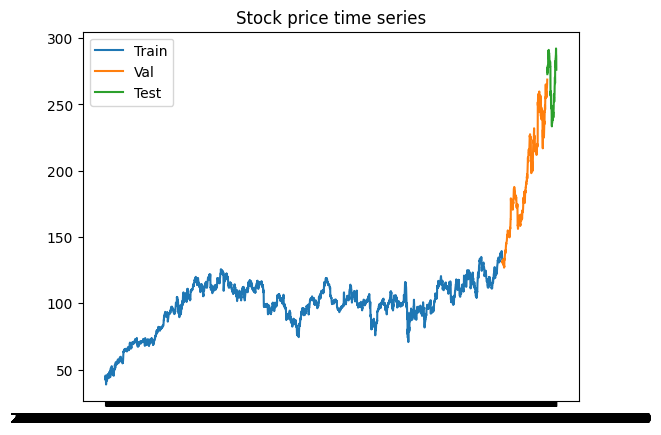

Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Linear Regression
Stock prediction on test data-  Linear Regression
Plotting actual vs predicted for-  Linear Regression


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


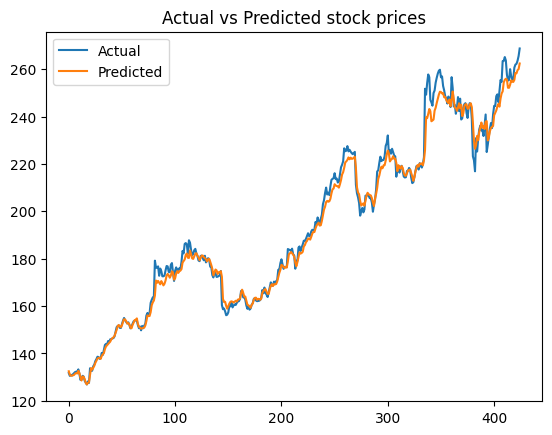

  
Training Random Forest model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Random Forest
Stock prediction on test data-  Random Forest
Plotting actual vs predicted for-  Random Forest


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


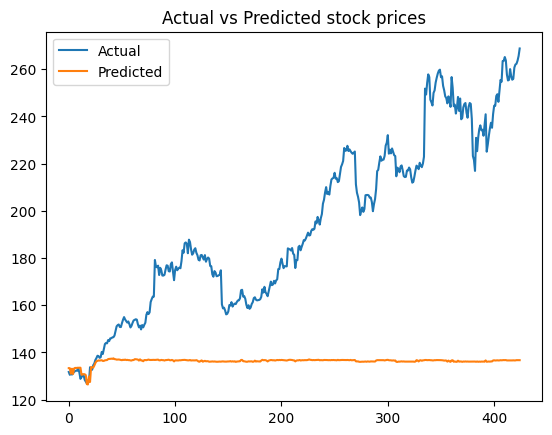

  
Training XGBoost model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for XGBoost
Stock prediction on test data-  XGBoost
Plotting actual vs predicted for-  XGBoost


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


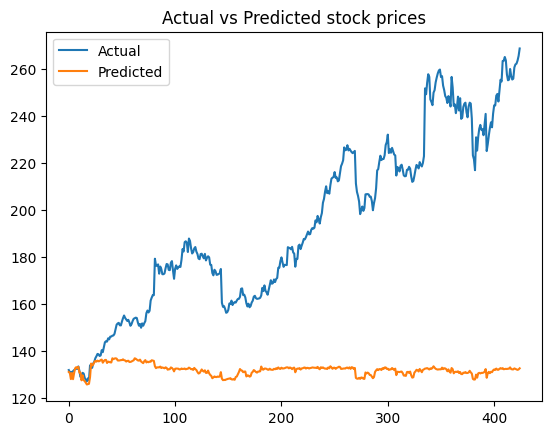

  
Training LSTM model
splitting the data into train and test
 
scaling features and targeting the LSTM
fetching historical data-  4254
Training Set length -  3700
Test Set length -  553
(3700, 70, 1) (554, 70, 1)
(3700, 1) (554, 1)


c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 70, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.1627 - mae: 0.2748 - val_loss: 0.6253 - val_mae: 0.6981 - learning_rate: 0.0010
Epoch 2/20
  7/232 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3031 - mae: 0.5486

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0583 - mae: 0.1791 - val_loss: 0.6233 - val_mae: 0.6973 - learning_rate: 0.0010
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0568 - mae: 0.1766 - val_loss: 0.6232 - val_mae: 0.6978 - learning_rate: 0.0010
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0545 - mae: 0.1741 - val_loss: 0.6224 - val_mae: 0.6977 - learning_rate: 0.0010
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0544 - mae: 0.1749 - val_loss: 0.6231 - val_mae: 0.6986 - learning_rate: 0.0010
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0534 - mae: 0.1733 - val_loss: 0.6223 - val_mae: 0.6984 - learning_rate: 0.0010
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0527 - mae: 0.1728 - val_loss: 0.6190 - val_mae: 0.6964 - learning_rate: 0.0010
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.0525 - mae: 0.1727 - val_loss: 0.6180 - val_mae: 0.6959 - learning_rate: 0.0010
Epoch 9/20

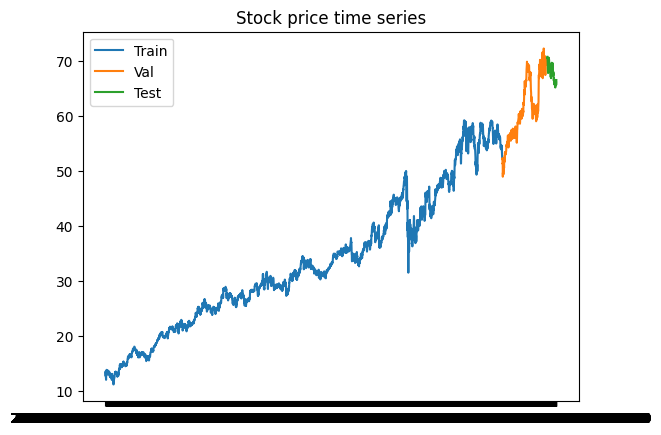

Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Linear Regression
Stock prediction on test data-  Linear Regression
Plotting actual vs predicted for-  Linear Regression


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


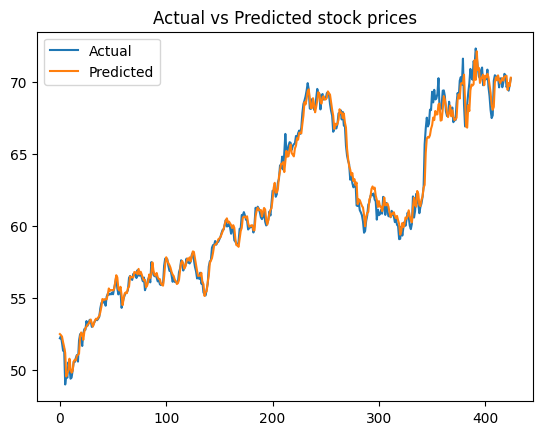

  
Training Random Forest model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Random Forest
Stock prediction on test data-  Random Forest
Plotting actual vs predicted for-  Random Forest


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


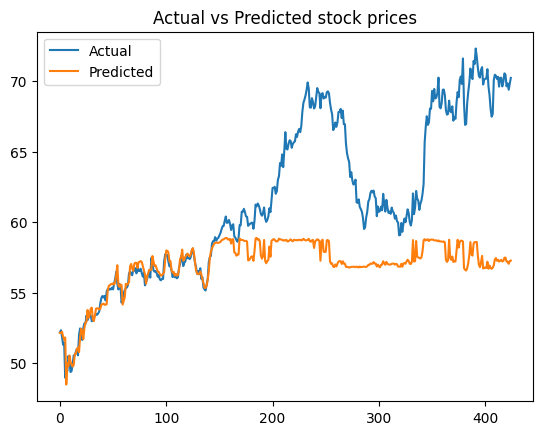

  
Training XGBoost model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for XGBoost
Stock prediction on test data-  XGBoost
Plotting actual vs predicted for-  XGBoost


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


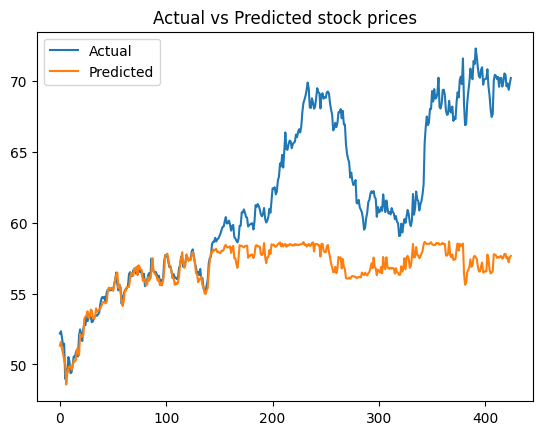

  
Training LSTM model
splitting the data into train and test
 
scaling features and targeting the LSTM
fetching historical data-  4254
Training Set length -  3700
Test Set length -  553
(3700, 70, 1) (554, 70, 1)
(3700, 1) (554, 1)


c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 70, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.1649 - mae: 0.2826 - val_loss: 0.1525 - val_mae: 0.3413 - learning_rate: 0.0010
Epoch 2/20
  5/232 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 1.5522 - mae: 1.2457

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.3462 - mae: 0.4059 - val_loss: 0.1640 - val_mae: 0.3577 - learning_rate: 0.0010
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.3407 - mae: 0.4089 - val_loss: 0.1723 - val_mae: 0.3694 - learning_rate: 0.0010
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.3359 - mae: 0.4097 - val_loss: 0.1759 - val_mae: 0.3746 - learning_rate: 0.0010
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.3325 - mae: 0.4094 - val_loss: 0.1792 - val_mae: 0.3794 - learning_rate: 0.0010
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.3263 - mae: 0.4068 - val_loss: 0.1783 - val_mae: 0.3788 - learning_rate: 0.0010
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.3200 - mae: 0.4032 - val_loss: 0.1750 - val_mae: 0.3751 - learning_rate: 0.0010
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.3153 - mae: 0.3991 - val_loss: 0.1712 - val_mae: 0.3706 - learning_rate: 0.0010
Epoch 9/20

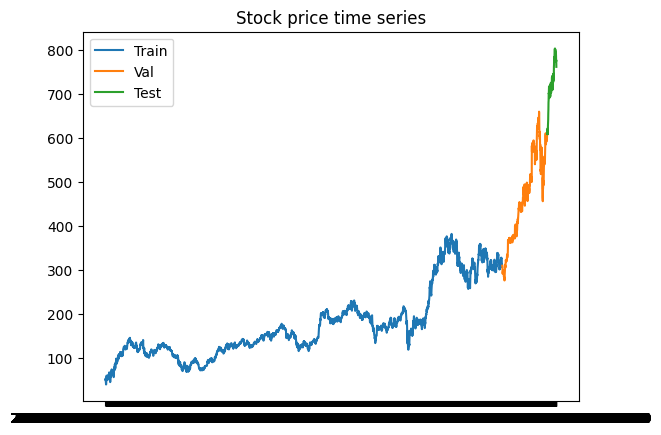

Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Linear Regression
Stock prediction on test data-  Linear Regression
Plotting actual vs predicted for-  Linear Regression


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


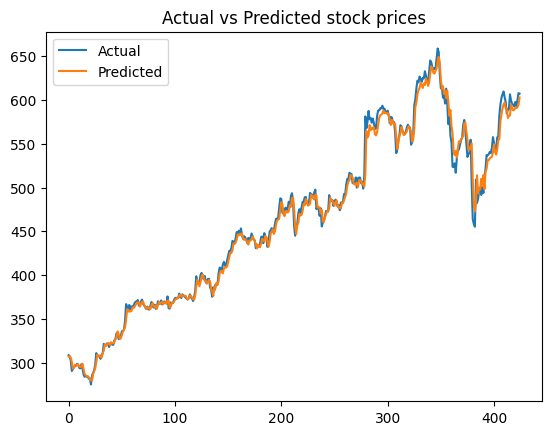

  
Training Random Forest model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Random Forest
Stock prediction on test data-  Random Forest
Plotting actual vs predicted for-  Random Forest


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


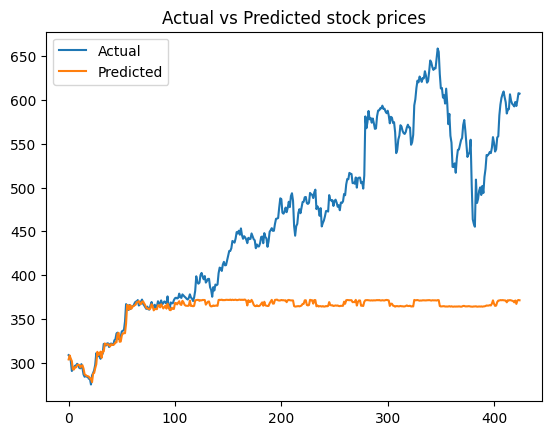

  
Training XGBoost model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for XGBoost
Stock prediction on test data-  XGBoost
Plotting actual vs predicted for-  XGBoost


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


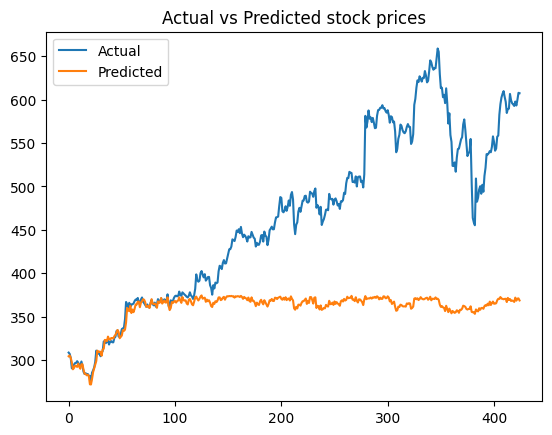

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  
Training LSTM model
splitting the data into train and test
 
scaling features and targeting the LSTM
fetching historical data-  4254
Training Set length -  3700
Test Set length -  553
(3700, 70, 1) (554, 70, 1)
(3700, 1) (554, 1)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 70, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.1642 - mae: 0.2816 - val_loss: 0.3905 - val_mae: 0.5100 - learning_rate: 0.0010
Epoch 2/20
  7/232 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.3961 - mae: 0.6280

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0714 - mae: 0.1905 - val_loss: 0.3909 - val_mae: 0.5114 - learning_rate: 0.0010
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.0685 - mae: 0.1881 - val_loss: 0.3879 - val_mae: 0.5097 - learning_rate: 0.0010
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0666 - mae: 0.1867 - val_loss: 0.3846 - val_mae: 0.5074 - learning_rate: 0.0010
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.0644 - mae: 0.1842 - val_loss: 0.3813 - val_mae: 0.5053 - learning_rate: 0.0010
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0627 - mae: 0.1818 - val_loss: 0.3758 - val_mae: 0.5010 - learning_rate: 0.0010
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0611 - mae: 0.1794 - val_loss: 0.3718 - val_mae: 0.4979 - learning_rate: 0.0010
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0591 - mae: 0.1763 - val_loss: 0.3666 - val_mae: 0.4938 - learning_rate: 0.0010
Epoch 9/20

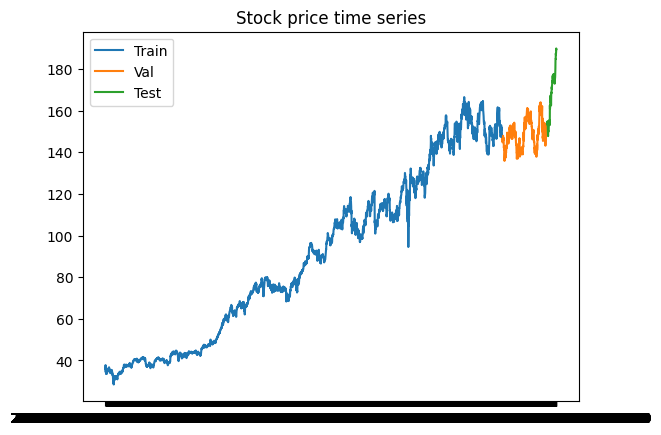

Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Linear Regression
Stock prediction on test data-  Linear Regression
Plotting actual vs predicted for-  Linear Regression


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


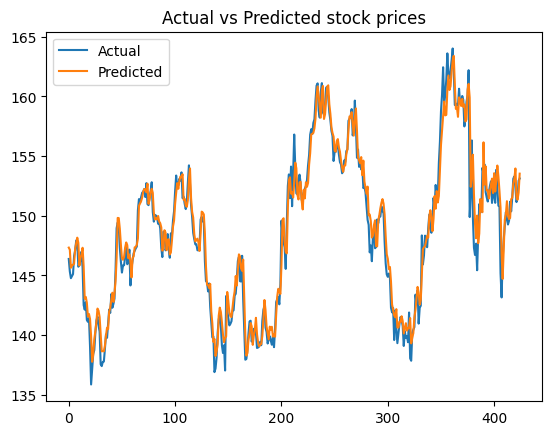

  
Training Random Forest model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Random Forest
Stock prediction on test data-  Random Forest
Plotting actual vs predicted for-  Random Forest


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


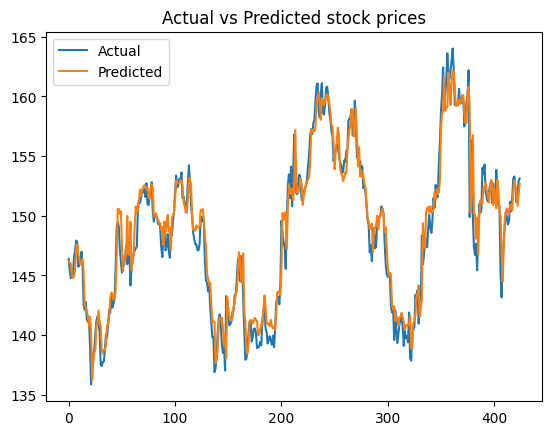

  
Training XGBoost model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for XGBoost
Stock prediction on test data-  XGBoost
Plotting actual vs predicted for-  XGBoost


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


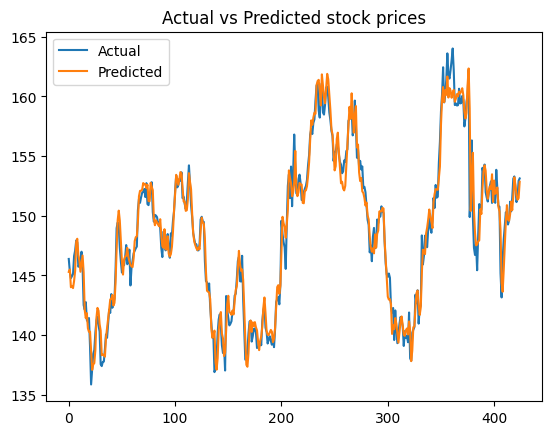

  
Training LSTM model
splitting the data into train and test
 
scaling features and targeting the LSTM
fetching historical data-  4254
Training Set length -  3700
Test Set length -  553
(3700, 70, 1) (554, 70, 1)
(3700, 1) (554, 1)


c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 70, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.2143 - mae: 0.3618 - val_loss: 0.0242 - val_mae: 0.1143 - learning_rate: 0.0010
Epoch 2/20
  7/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1.6764 - mae: 1.2943

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.4400 - mae: 0.5115 - val_loss: 0.0256 - val_mae: 0.1189 - learning_rate: 0.0010
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.4285 - mae: 0.5077 - val_loss: 0.0247 - val_mae: 0.1168 - learning_rate: 0.0010
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.4150 - mae: 0.5001 - val_loss: 0.0219 - val_mae: 0.1091 - learning_rate: 0.0010
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.4032 - mae: 0.4898 - val_loss: 0.0203 - val_mae: 0.1044 - learning_rate: 0.0010
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.3796 - mae: 0.4710 - val_loss: 0.0174 - val_mae: 0.0952 - learning_rate: 0.0010
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.3662 - mae: 0.4590 - val_loss: 0.0152 - val_mae: 0.0882 - learning_rate: 0.0010
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.3393 - mae: 0.4341 - val_loss: 0.0140 - val_mae: 0.0854 - learning_rate: 0.0010
Epoch 9/20

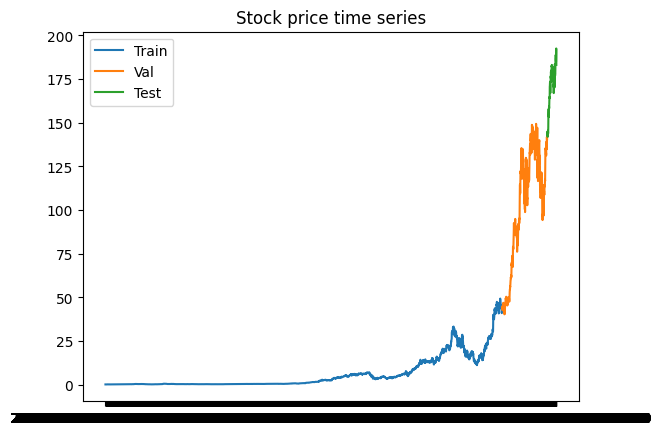

Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Linear Regression
Stock prediction on test data-  Linear Regression
Plotting actual vs predicted for-  Linear Regression


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


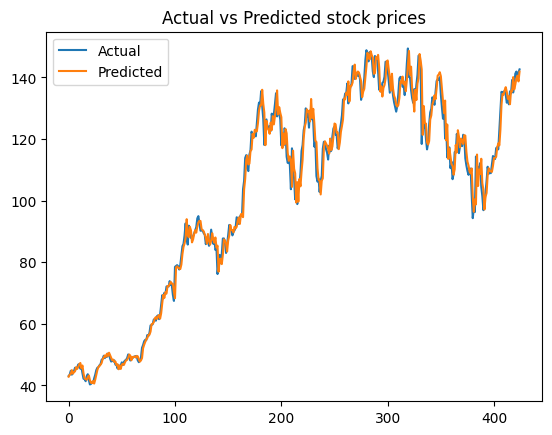

  
Training Random Forest model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for Random Forest
Stock prediction on test data-  Random Forest
Plotting actual vs predicted for-  Random Forest


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


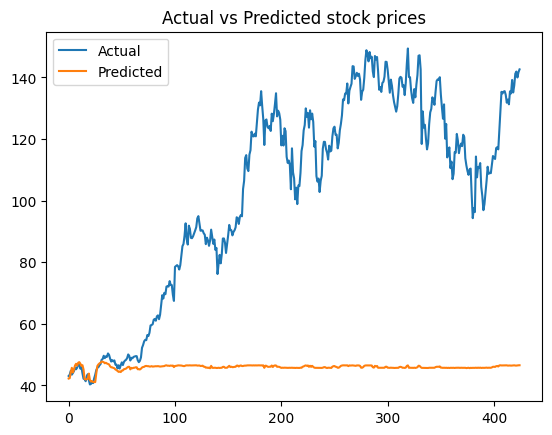

  
Training XGBoost model
splitting the data into train and test
 
Historic Stock data length is -  4254
Training set length-  3743
Validation dataset length-  85
(3743, 70) (86, 70) (425, 70)
(3743,) (86,) (425,)
Evaluating metrics- MAE, MAPE, RMSE, R SQUARE
 
update the metrics tracker....
 
Predicted vs actual for XGBoost
Stock prediction on test data-  XGBoost
Plotting actual vs predicted for-  XGBoost


C:\Users\Aaditya Saini\AppData\Local\Temp\ipykernel_41480\3790066201.py:317: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  self.df_pred.loc[:,'Date'] = pd.to_datetime(self.df_pred['Date'], format='ISO8601')


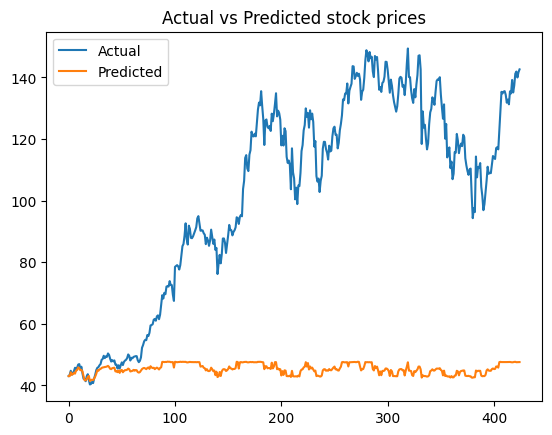

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  
Training LSTM model
splitting the data into train and test
 
scaling features and targeting the LSTM
fetching historical data-  4254
Training Set length -  3700
Test Set length -  553
(3700, 70, 1) (554, 70, 1)
(3700, 1) (554, 1)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 70, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.1826 - mae: 0.2853 - val_loss: 1.0864 - val_mae: 0.9403 - learning_rate: 0.0010
Epoch 2/20
  7/232 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0625 - mae: 0.2457

c:\Users\Aaditya Saini\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_mean_absolute_error` which is not available. Available metrics are: loss,mae,val_loss,val_mae,learning_rate.
  callback.on_epoch_end(epoch, logs)


232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0163 - mae: 0.0966 - val_loss: 1.0694 - val_mae: 0.9324 - learning_rate: 0.0010
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0155 - mae: 0.0934 - val_loss: 1.0591 - val_mae: 0.9279 - learning_rate: 0.0010
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0141 - mae: 0.0898 - val_loss: 1.0533 - val_mae: 0.9255 - learning_rate: 0.0010
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0132 - mae: 0.0864 - val_loss: 1.0384 - val_mae: 0.9182 - learning_rate: 0.0010
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0125 - mae: 0.0837 - val_loss: 1.0363 - val_mae: 0.9177 - learning_rate: 0.0010
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0116 - mae: 0.0802 - val_loss: 1.0309 - val_mae: 0.9153 - learning_rate: 0.0010
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0108 - mae: 0.0776 - val_loss: 1.0226 - val_mae: 0.9113 - learning_rate: 0.0010
Epoch 9/20

In [15]:
stocks = ['NKE', 'IBM', 'KO', 'GS', 'JNJ', 'NVDA']
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LSTM']
training = stock_prediction(stocks, models)
training.pipeline_sequence()

In [17]:
import json

with open('metrics.txt') as f:
    eval_metrics=json.load(f)

print(eval_metrics)

{'NKE': {'Linear Regression': {'Train_MAE': 0.72, 'Train_RSq': 1.0, 'Train_MAPE': 1.63, 'Train_RMSE': 1.16, 'Val_MAE': 1.19, 'Val_RSq': 0.99, 'Val_MAPE': 1.52, 'Val_RMSE': 1.76}, 'Random Forest': {'Train_MAE': 0.24, 'Train_RSq': 1.0, 'Train_MAPE': 0.4, 'Train_RMSE': 0.46, 'Val_MAE': 1.57, 'Val_RSq': 0.98, 'Val_MAPE': 2.07, 'Val_RMSE': 2.3}, 'XGBoost': {'Train_MAE': 0.22, 'Train_RSq': 1.0, 'Train_MAPE': 0.52, 'Train_RMSE': 0.3, 'Val_MAE': 1.53, 'Val_RSq': 0.98, 'Val_MAPE': 2.04, 'Val_RMSE': 2.23}, 'LSTM': {'Train_MAE': 26.03, 'Train_RSq': 0.38, 'Train_MAPE': 120.41, 'Train_RMSE': 31.45, 'Test_MAE': 37.58, 'Test_RSq': -7.01, 'Test_MAPE': 50.72, 'Test_RMSE': 40.75}}, 'IBM': {'Linear Regression': {'Train_MAE': 0.63, 'Train_RSq': 1.0, 'Train_MAPE': 0.66, 'Train_RMSE': 0.92, 'Val_MAE': 2.56, 'Val_RSq': 0.99, 'Val_MAPE': 1.23, 'Val_RMSE': 3.94}, 'Random Forest': {'Train_MAE': 0.29, 'Train_RSq': 1.0, 'Train_MAPE': 0.31, 'Train_RMSE': 0.46, 'Val_MAE': 57.42, 'Val_RSq': -2.3, 'Val_MAPE': 27.0, '

In [18]:
Metrics = pd.DataFrame.from_dict({(i,j): eval_metrics[i][j] 
                           for i in eval_metrics.keys() 
                           for j in eval_metrics[i].keys()},
                       orient='index')
Metrics

Train_MAE  Train_RSq  Train_MAPE  Train_RMSE  Val_MAE  \
NKE  Linear Regression       0.72       1.00        1.63        1.16     1.19   
     Random Forest           0.24       1.00        0.40        0.46     1.57   
     XGBoost                 0.22       1.00        0.52        0.30     1.53   
     LSTM                   26.03       0.38      120.41       31.45      NaN   
IBM  Linear Regression       0.63       1.00        0.66        0.92     2.56   
     Random Forest           0.29       1.00        0.31        0.46    57.42   
     XGBoost                 0.27       1.00        0.28        0.34    61.71   
     LSTM                   14.19      -0.27       18.38       19.76      NaN   
KO   Linear Regression       0.21       1.00        0.68        0.32     0.42   
     Random Forest           0.08       1.00        0.25        0.14     4.69   
     XGBoost                 0.08       1.00        0.27        0.11     4.81   
     LSTM                   10.51      -0.09       46.87       12.62      NaN   
GS   Linear Regression       1.90       1.00        1.21        2.64     5.94   
     Random Forest           0.74       1.00        0.46        1.13   104.72   
     XGBoost                 0.74       1.00        0.50        0.95   105.55   
     LSTM                  104.56      -1.24       85.82      114.66      NaN   
JNJ  Linear Regression       0.61       1.00        0.77        0.89     1.03   
     Random Forest           0.21       1.00        0.24        0.36     1.20   
     XGBoost                 0.21       1.00        0.27        0.28     0.91   
     LSTM                   25.97       0.26       53.33       34.35      NaN   
NVDA Linear Regression       0.17       1.00       11.28        0.34     2.67   
     Random Forest           0.05       1.00        0.68        0.13    56.56   
     XGBoost                 0.03       1.00        1.32        0.05    57.05   
     LSTM                   12.55      -1.51     2334.70       13.29      NaN   

                        Val_RSq  Val_MAPE  Val_RMSE  Test_MAE  Test_RSq  \
NKE  Linear Regression     0.99      1.52      1.76       NaN       NaN   
     Random Forest         0.98      2.07      2.30       NaN       NaN   
     XGBoost               0.98      2.04      2.23       NaN       NaN   
     LSTM                   NaN       NaN       NaN     37.58     -7.01   
IBM  Linear Regression     0.99      1.23      3.94       NaN       NaN   
     Random Forest        -2.30     27.00     68.30       NaN       NaN   
     XGBoost              -2.71     29.18     72.45       NaN       NaN   
     LSTM                   NaN       NaN       NaN     87.87     -3.52   
KO   Linear Regression     0.99      0.67      0.61       NaN       NaN   
     Random Forest        -0.27      7.06      6.53       NaN       NaN   
     XGBoost              -0.32      7.24      6.65       NaN       NaN   
     LSTM                   NaN       NaN       NaN      7.29     -1.16   
GS   Linear Regression     0.99      1.21      9.29       NaN       NaN   
     Random Forest        -0.89     19.56    135.87       NaN       NaN   
     XGBoost              -0.92     19.71    136.98       NaN       NaN   
     LSTM                   NaN       NaN       NaN    174.06     -1.43   
JNJ  Linear Regression     0.95      0.70      1.45       NaN       NaN   
     Random Forest         0.94      0.81      1.66       NaN       NaN   
     XGBoost               0.96      0.61      1.25       NaN       NaN   
     LSTM                   NaN       NaN       NaN      6.91      0.18   
NVDA Linear Regression     0.99      2.53      3.80       NaN       NaN   
     Random Forest        -2.91     48.30     65.26       NaN       NaN   
     XGBoost              -2.97     48.79     65.73       NaN       NaN   
     LSTM                   NaN       NaN       NaN     85.70     -3.99   

                        Test_MAPE  Test_RMSE  
NKE  Linear Regression        NaN        NaN  
     Random Forest          

In [22]:

pd.DataFrame(training.metrics).to_csv('evaluation.csv')